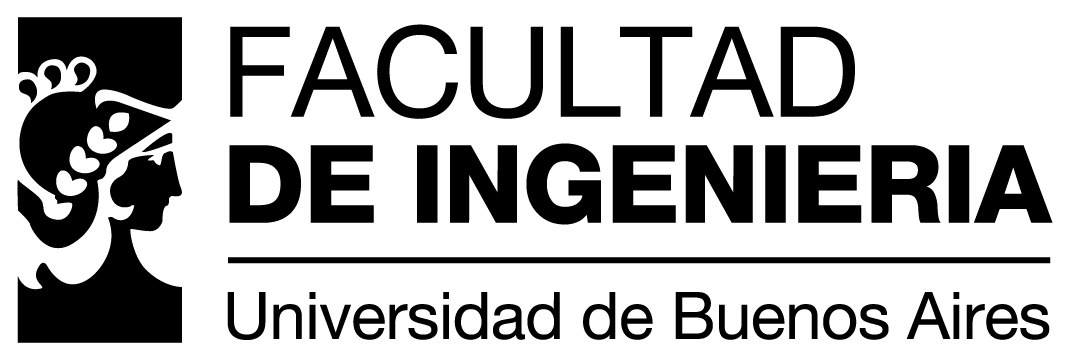

# Trabajo Practico: Sistema Oscilatorio Amortiguado

### **Integrantes**

| **Alumno**       | **Padrón** | **E-mail**          |
|-------------------|-----------|---------------------|
| Máximo Utrera     | 109651    | mutrera@fi.uba.ar   |
| Marcos Torasso    | 100959    | mtorasso@fi.uba.ar  |
| Lucas Jang        | 109151    | ljang@fi.uba.ar     |


*Modelacion Numerica - 2° Cuatrimestre 2024*


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
from scipy.optimize import minimize

# Ponderado implicito

In [ ]:
def ponderado_implicito(beta, dt, t_max, k, m, lmbda=0, c_0=0, c_velocity=0, c_func=None, u_0=0, v_0=0, **kwargs):
    t = np.arange(0, t_max + dt, dt, dtype=np.float64)
    u = np.zeros_like(t, dtype=np.float64)
    v = np.zeros_like(t, dtype=np.float64)

    c_pos = np.full_like(t, c_0, dtype=np.float64)
    c_vel = np.full_like(t, c_velocity, dtype=np.float64)

    if c_func:
      for i, ti in enumerate(t):
          c_pos[i], c_vel[i] = c_func(ti)

    u[0] = u_0
    v[0] = v_0

    for n in range(len(t) - 1):
        # Estimaciones iniciales
        u_next = u[n]
        v_next = v[n]

        # Iteración para resolver sistema implícito (20 iters o err < max_err)
        for _ in range(kwargs.get("max_iters", 50)):
            g_n = g(u[n], v[n], k, m, c_pos[n], c_vel[n], lmbda)
            g_next = g(u_next, v_next, k, m, c_pos[n+1], c_vel[n+1], lmbda)

            u_next_new = u[n] + dt * ((1 - beta) * f(v[n]) + beta * f(v_next))
            v_next_new = v[n] + dt * ((1 - beta) * g_n + beta * g_next)

            # Verificar convergencia
            if (np.abs(u_next_new - u_next, dtype=np.float64) < kwargs.get("max_err", 1e-12) and
            np.abs(v_next_new - v_next, dtype=np.float64) < kwargs.get("max_err", 1e-12)):
                break

            u_next = u_next_new
            v_next = v_next_new

        u[n + 1] = u_next
        v[n + 1] = v_next

    return t, u, v, c_pos, c_vel

def f(v):
  return v

def g(u, v, k, m, c_0, c_velocity, lmbda):
    return (k / m) * (c_0 - u) + (lmbda / m) * (c_velocity - v)

# Oscilador armónico con excitación uniforme

## Resolucion y comparacion inicial

In [ ]:
# Parámetros iniciales
m = 109651 / 200
k = 25000
c = 0.1
c_velocity = 0
t_final = 5
dt = 0.005

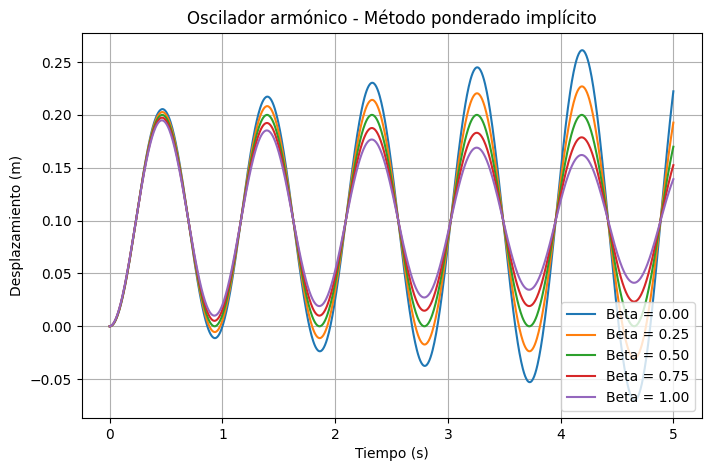

In [ ]:
betas = np.arange(0, 1.25, 0.25)

plt.figure(figsize=(8, 5))

for beta in betas:
    t, u, v, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c)
    plt.plot(t, u, label=f"Beta = {beta:.2f}")

plt.title("Oscilador armónico - Método ponderado implícito")
plt.xlabel("Tiempo (s)")
plt.ylabel("Desplazamiento (m)")
plt.legend()
plt.grid()
plt.show()

## Analisis de estabilidad variando β y Δt

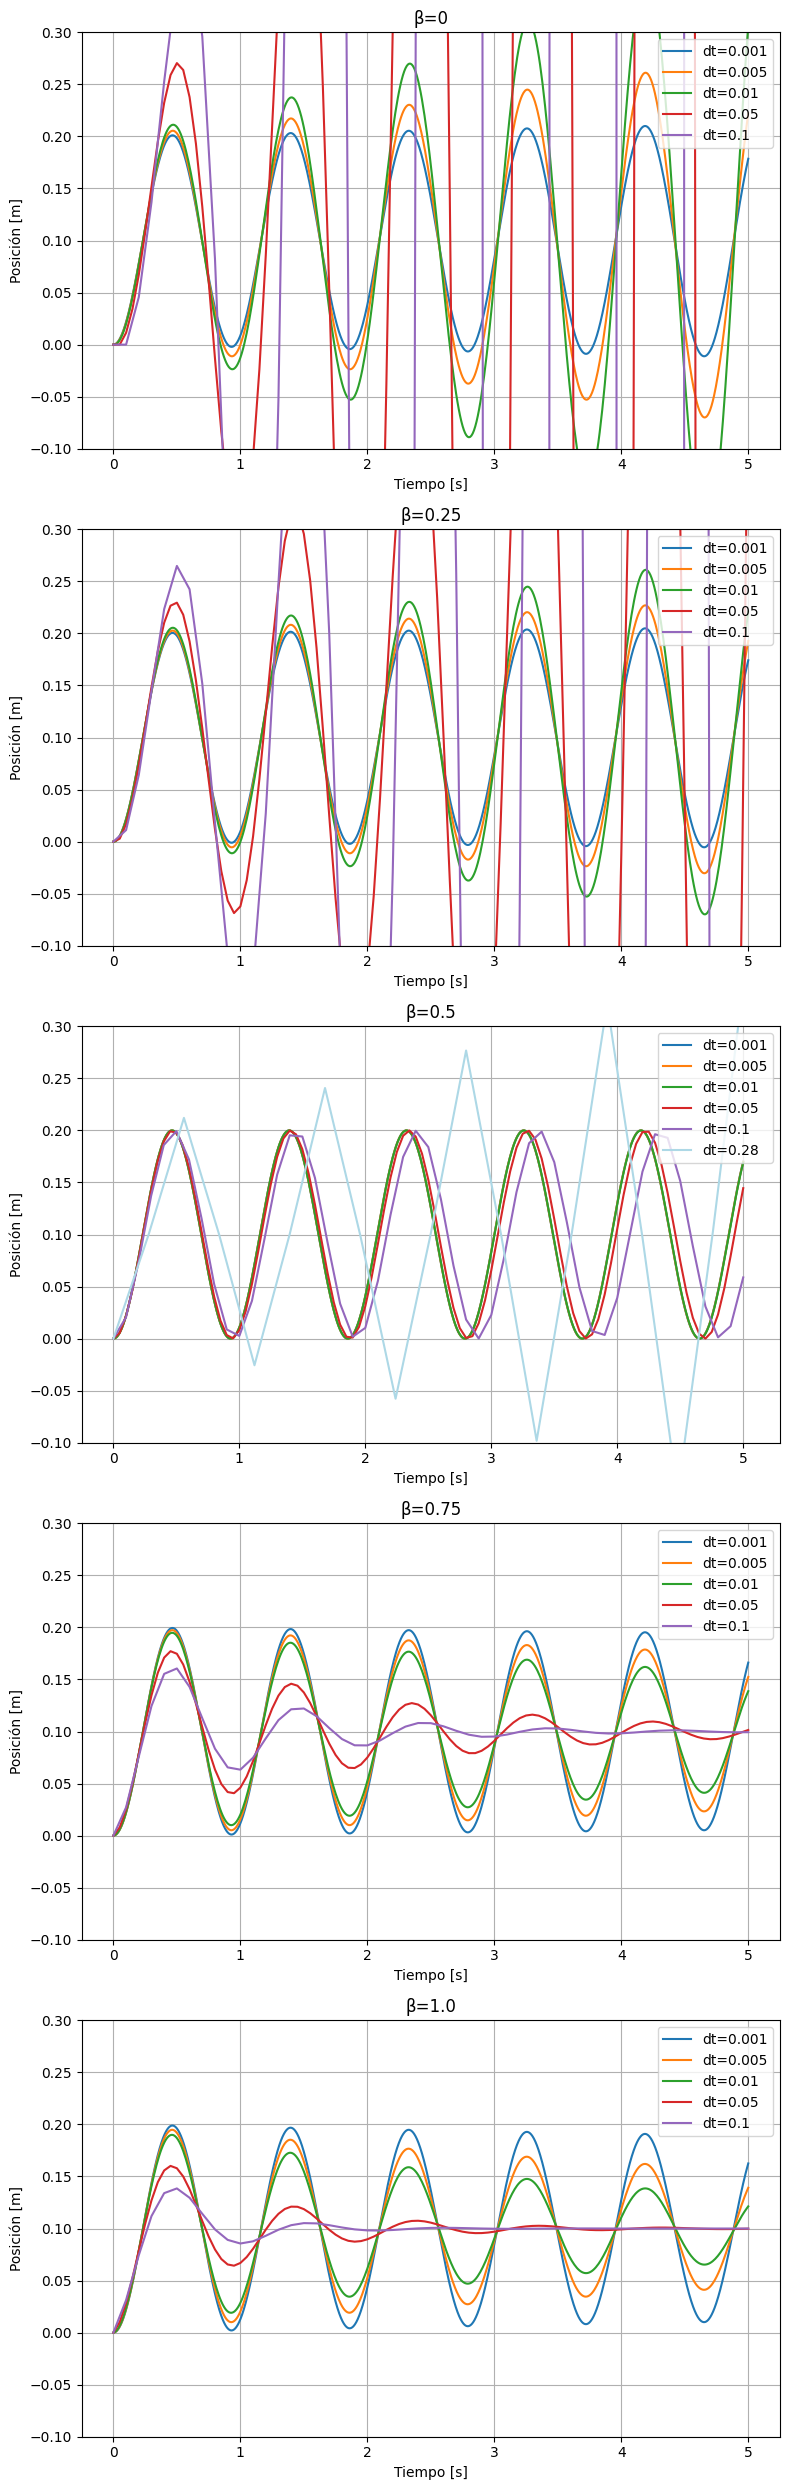

In [ ]:
def analizar_estabilidad():
    dt_values = [0.001, 0.005, 0.01, 0.05, 0.1]
    betas = [0, 0.25, 0.5, 0.75, 1.0]

    # subplot para cada beta
    fig, axs = plt.subplots(len(betas), 1, figsize=(8, 5*len(betas)))

    for i, beta in enumerate(betas):
        for dt in dt_values:
            t, u, v, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c)
            axs[i].plot(t, u, label=f'dt={dt}')
        if beta == 0.5: # Para evaluar estabilidad
          dt = 0.28
          t, u, v, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c)
          axs[i].plot(t, u, label=f'dt={dt}', color='lightblue')

        axs[i].grid(True)
        axs[i].set_xlabel('Tiempo [s]')
        axs[i].set_ylabel('Posición [m]')
        axs[i].set_title(f'β={beta}')
        axs[i].set_ylim(-0.1, 0.3)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

analizar_estabilidad()

## Δt Optimo

Se observa que un paso de tiempo en el cual todos los metodos dan resultados aceptables es **0.005**, sin embargo el mejor paso de tiempo probado es **0.001** y es el que se usara para las resoluciones de sistemas, sin embargo se usara el anterior Δt mencionado en algunas comparaciones.

Tambien se observa que el metodo que mas se mantiene cerca de la solucion es cuando **β es 0.5**, ya que los betas menores divergen con un paso muy grande y los betas mas grandes convergen a una recta constante donde el error no crece ni decrece.

## Frecuencia natural

In [ ]:
omega_n = np.sqrt(k / m)
print(f"Frecuencia natural analítica: {omega_n:.4f} rad/s")

def estimar_frecuencia(t, u):
    """Estima la frecuencia natural a partir del período de oscilación."""
    indices_max = (np.diff(np.sign(np.diff(u))) < 0).nonzero()[0] + 1
    if len(indices_max) > 1:
        periodos = np.diff(t[indices_max])
        frecuencia_exp = 1 / np.mean(periodos)
        return frecuencia_exp
    else:
        return None

beta = 0.5
t, u, v, _, _ = ponderado_implicito(beta, 0.005, t_final, k, m, c_0=c)
frecuencia_exp = estimar_frecuencia(t, u)
if frecuencia_exp:
    print(f"Frecuencia natural experimental: {2 * np.pi * frecuencia_exp:.4f} rad/s")
else:
    print("No se pudo estimar la frecuencia experimental.")

Frecuencia natural analítica: 6.7527 rad/s
Frecuencia natural experimental: 6.7470 rad/s


## Analisis del error

In [ ]:
def sol_analitica_parte_1(t, c_0, omega_n):
    return c_0 * (1 - np.cos(omega_n * t))

def calculate_error(u_numerica, t, omega_n):
    u_exacta = sol_analitica_parte_1(t, c, omega_n)
    return np.mean(np.abs(u_numerica - u_exacta, dtype=np.float64))

### Ordenes de convergencia


Órdenes de convergencia:
β=0: Orden = 1.07
β=0.25: Orden = 1.03
β=0.5: Orden = 2.00
β=0.75: Orden = 0.97
β=1.0: Orden = 0.94


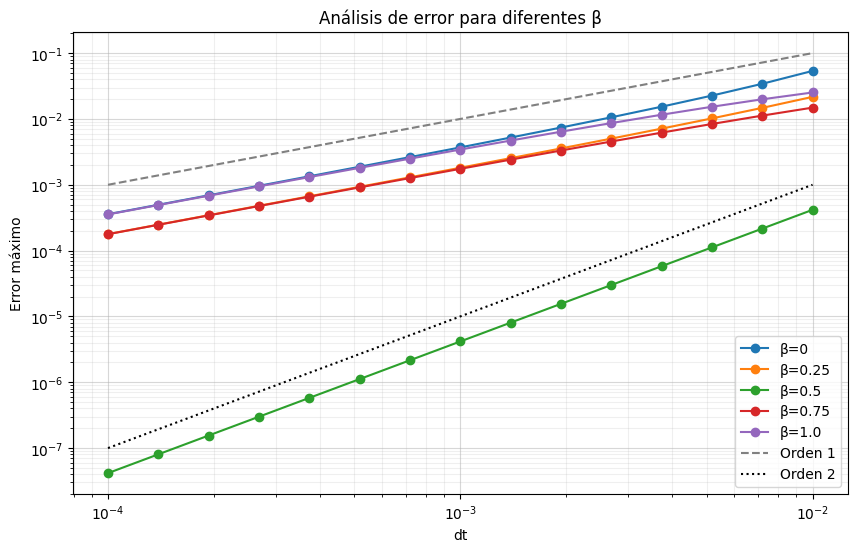

In [ ]:
def calcular_orden_convergencia(dt_values, errors):
    """Calcula el orden de convergencia mediante ajuste lineal en escala log-log."""
    ln_dt = np.log(dt_values)
    ln_errors = np.log(errors)
    coef = np.polyfit(ln_dt, ln_errors, 1)  # Ajuste lineal
    return coef[0]  # La pendiente representa el orden

def analizar_error_multiple():
    dt_values = np.logspace(-4, -2, 15)
    betas = [0, 0.25, 0.5, 0.75, 1.0]

    plt.figure(figsize=(10, 6))

    print("\nÓrdenes de convergencia:")

    for beta in betas:
        errors = []
        for dt in dt_values:
            t, u, v, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c)
            error = calculate_error(u, t, omega_n)
            errors.append(error)

        # Calcular orden de convergencia
        orden = calcular_orden_convergencia(dt_values, errors)
        print(f"β={beta}: Orden = {orden:.2f}")

        plt.loglog(dt_values, errors, 'o-', label=f'β={beta}')

    # Lineas orden 1 y 2
    ref_1 = dt_values * 10
    ref_2 = dt_values**2 * 10

    plt.loglog(dt_values, ref_1, '--', label='Orden 1', color='gray')
    plt.loglog(dt_values, ref_2, ':', label='Orden 2', color='black')

    plt.grid(True)
    plt.xlabel('dt')
    plt.ylabel('Error máximo')
    plt.title('Análisis de error para diferentes β')
    plt.legend()

    plt.grid(True, which="minor", ls="-", alpha=0.2)
    plt.grid(True, which="major", ls="-", alpha=0.5)

    plt.show()

analizar_error_multiple()

### Comparacion de β = 0.5 y Δt = 0.001 con analitica

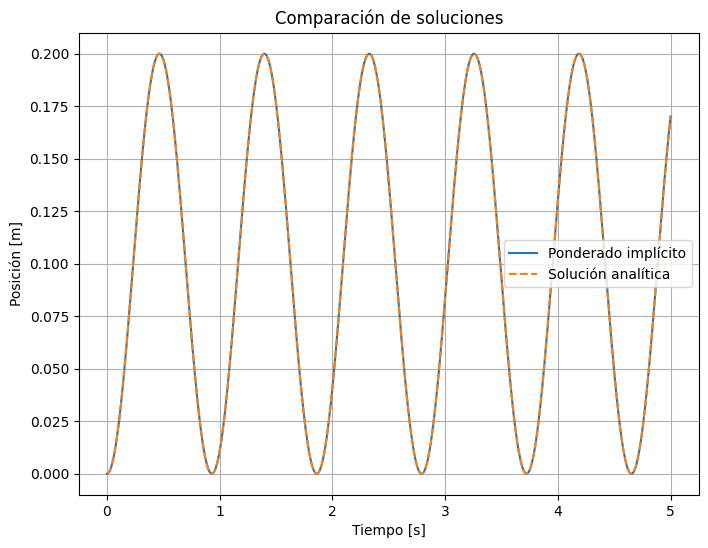

In [ ]:
t, y, v, _, _ = ponderado_implicito(0.5, 0.001, t_final, k, m, c_0=c)
y_exact = sol_analitica_parte_1(t, c, omega_n)

plt.figure(figsize=(8, 6))
plt.plot(t, y, label='Ponderado implícito')
plt.plot(t, y_exact, label='Solución analítica', linestyle='--')
plt.grid(True)
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.title('Comparación de soluciones')
plt.legend()
plt.show()

## Tiempos de calculo

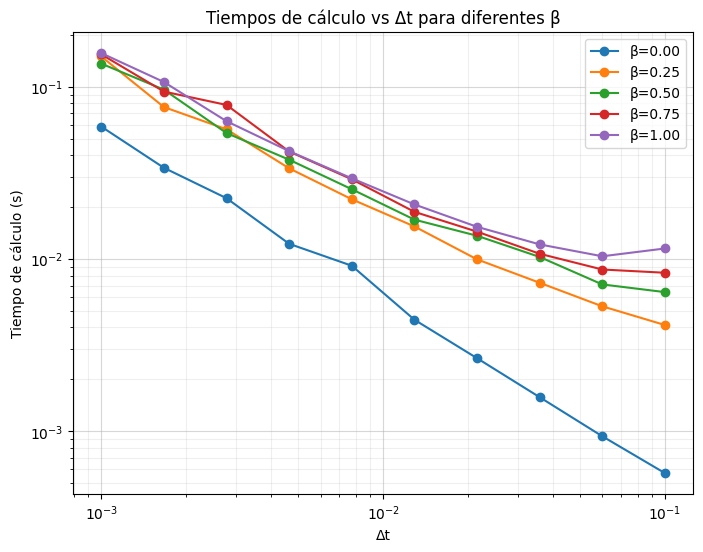


Tiempos de cálculo (segundos):
+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Beta   |   dt=1.0e-03 |   dt=1.7e-03 |   dt=2.8e-03 |   dt=4.6e-03 |   dt=7.7e-03 |   dt=1.3e-02 |   dt=2.2e-02 |   dt=3.6e-02 |   dt=6.0e-02 |   dt=1.0e-01 |
+========+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
| β=0.00 |       0.0587 |       0.0338 |       0.0225 |       0.0122 |       0.0091 |       0.0044 |       0.0027 |       0.0016 |       0.0009 |       0.0006 |
+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| β=0.25 |       0.1498 |       0.0762 |       0.0566 |       0.0336 |       0.0222 |       0.0154 |       0.0099 |       0.0073 |       0.0053 |       0.0041 |
+-

In [ ]:
def medir_tiempos_calculo():
    betas = np.arange(0, 1.25, 0.25)
    dt_values = np.logspace(-3, -1, 10)

    tiempos = np.zeros((len(betas), len(dt_values)))

    for i, beta in enumerate(betas):
        for j, dt in enumerate(dt_values):
            inicio = time.perf_counter()
            _, _, _, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c)
            fin = time.perf_counter()

            tiempos[i, j] = fin - inicio

    plt.figure(figsize=(8, 6))

    # Gráfico de tiempos
    for i, beta in enumerate(betas):
        plt.loglog(dt_values, tiempos[i], 'o-', label=f'β={beta:.2f}')

    plt.grid(True)
    plt.xlabel('Δt')
    plt.ylabel('Tiempo de cálculo (s)')
    plt.title('Tiempos de cálculo vs Δt para diferentes β')
    plt.legend()

    # Agregar cuadrícula
    plt.grid(True, which="minor", ls="-", alpha=0.2)
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.show()

    # Resultados
    print("\nTiempos de cálculo (segundos):")
    headers = [f"dt={dt:.1e}" for dt in dt_values]
    table_data = []

    for i, beta in enumerate(betas):
        row = [f"β={beta:.2f}"] + [f"{t:.4f}" for t in tiempos[i]]
        table_data.append(row)

    print(tabulate(table_data, headers=["Beta"] + headers, tablefmt="grid"))

    # Stats
    print("\nEstadísticas:")
    print(f"Tiempo total de cálculo: {np.sum(tiempos):.4f} segundos")
    print(f"Tiempo promedio por simulación: {np.mean(tiempos):.4f} segundos")
    print(f"Tiempo máximo: {np.max(tiempos):.4f} segundos (β={betas[np.unravel_index(np.argmax(tiempos), tiempos.shape)[0]]:.2f}, dt={dt_values[np.unravel_index(np.argmax(tiempos), tiempos.shape)[1]]:.1e})")
    print(f"Tiempo mínimo: {np.min(tiempos):.4f} segundos (β={betas[np.unravel_index(np.argmin(tiempos), tiempos.shape)[0]]:.2f}, dt={dt_values[np.unravel_index(np.argmin(tiempos), tiempos.shape)[1]]:.1e})")

medir_tiempos_calculo()

**Obs:** a medida que el metodo se asemeja mas a su forma explicita pura disminuye su tiempo de ejecucion, es decir 0 < 0.25 < 0.5 < 0.75 < 1 (tiempo para cada β)

# Oscilador amortiguado accionado por un lomo de burro

## Resolucion de sistema con loma de burro

In [ ]:
# Parámetros del sistema
m = 109651 / 200
k = 25000
lmbda = 750
dt = 0.001
t_final = 5.0

In [ ]:
def obtener_c_segunda_parte(t):
    """ Function de C y C_vel a lo largo de t """
    if t < 1.0:
        return 0.0, 0.0
    elif t < 1.2:  # Rampa ascendente
        return 0.1 * (t - 1.0) / 0.2, 0.1 / 0.2  # pendiente = 0.5 m/s
    elif t < 1.4:
        return 0.1, 0.0
    elif t < 1.6:  # Rampa descendente
        return 0.1 * (1.0 - (t - 1.4) / 0.2), -0.1 / 0.2  # pendiente = -0.5 m/s
    else:
        return 0.0, 0.0

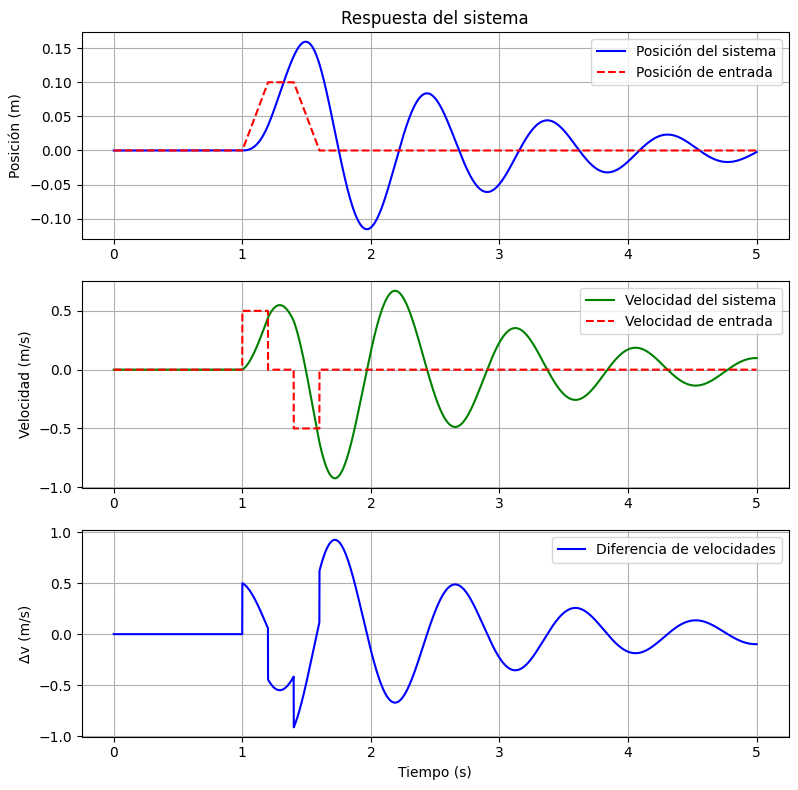

In [ ]:
# Resolver sistema
t, u, v, c_pos, c_vel = ponderado_implicito(0.5, dt, t_final, k, m, lmbda, c_func=obtener_c_segunda_parte)

plt.figure(figsize=(8, 8))

# Posición
plt.subplot(3, 1, 1)
plt.plot(t, u, 'b-', label='Posición del sistema')
plt.plot(t, c_pos, 'r--', label='Posición de entrada')
plt.grid(True)
plt.ylabel('Posición (m)')
plt.legend()
plt.title('Respuesta del sistema')

# Velocidad del sistema
plt.subplot(3, 1, 2)
plt.plot(t, v, 'g-', label='Velocidad del sistema')
plt.plot(t, c_vel, 'r--', label='Velocidad de entrada')
plt.grid(True)
plt.ylabel('Velocidad (m/s)')
plt.legend()

# Diferencia de velocidades
plt.subplot(3, 1, 3)
plt.plot(t, c_vel - v, 'b-', label='Diferencia de velocidades')
plt.grid(True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Δv (m/s)')
plt.legend()

plt.tight_layout()
plt.show()

## Comparacion de los distintos β con amortiguacion (λ)

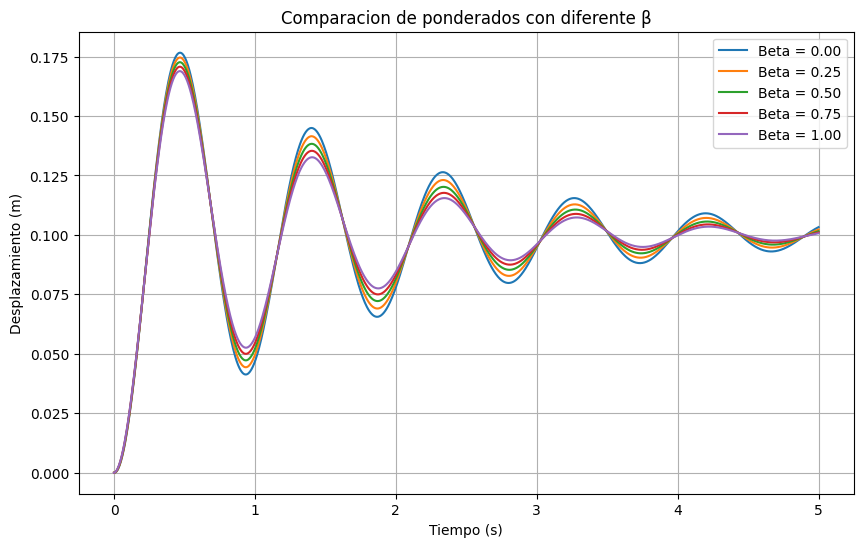

In [ ]:
dt = 0.005
betas = np.arange(0, 1.25, 0.25)

# Simulación para distintos valores de beta
plt.figure(figsize=(10, 6))
for beta in betas:
    t, u, v, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c_0=c, lmbda=lmbda)
    plt.plot(t, u, label=f"Beta = {beta:.2f}")

plt.title("Comparacion de ponderados con diferente β")
plt.xlabel("Tiempo (s)")
plt.ylabel("Desplazamiento (m)")
plt.legend()
plt.grid()
plt.show()

## Busqueda de k y λ apropiado

* El sistema de amortiguación no puede comprimirse más de 0.05 m, es decir y − c ≥ −0.05 m.
* La aceleración vertical y′′ al pasar por el lomo de burro debe minimizarse.
* Las oscilaciones en la carrocería después del lomo de burro deben minimizarse.

In [ ]:
def evaluar_sistema(params):
    k, lmbda = params
    t, u, v, c_pos, c_vel = ponderado_implicito(0.5, dt, t_final, k, m, lmbda, c_func=obtener_c_segunda_parte)

    compresion = u - c_pos
    min_compresion = np.min(compresion)

    # Penalización por compresión fuera del límite
    penalizacion_compresion = 0
    if min_compresion < -0.05:
        penalizacion_compresion += 1000 * abs(min_compresion + 0.05)

    # Aceleracion a lo largo de t
    a = (k / m) * (c_pos - u) + (lmbda / m) * (c_vel - v)
    max_aceleracion = np.max(np.abs(a))

    # Oscilaciones despues de loma
    post_event_index = int(1.5 / dt)  # Desde t = 1.5 s en adelante
    oscilaciones = np.var(u[post_event_index:])

    return penalizacion_compresion + max_aceleracion + oscilaciones

params_iniciales = [k, lmbda]  # k y lambda actuales

rango = [(5000, 40000),  # Rango para k
          (100, 5000)]    # Rango para lambda

resultado = minimize(evaluar_sistema, params_iniciales, bounds=rango, method='L-BFGS-B')

# Resultados óptimos
k_opt, lmbda_opt = resultado.x
print(f"Valores óptimos: k = {k_opt}, lambda = {lmbda_opt}")


Valores óptimos: k = 16616.99683536632, lambda = 2839.088110750211


## Comparacion de k y λ iniciales vs optimos

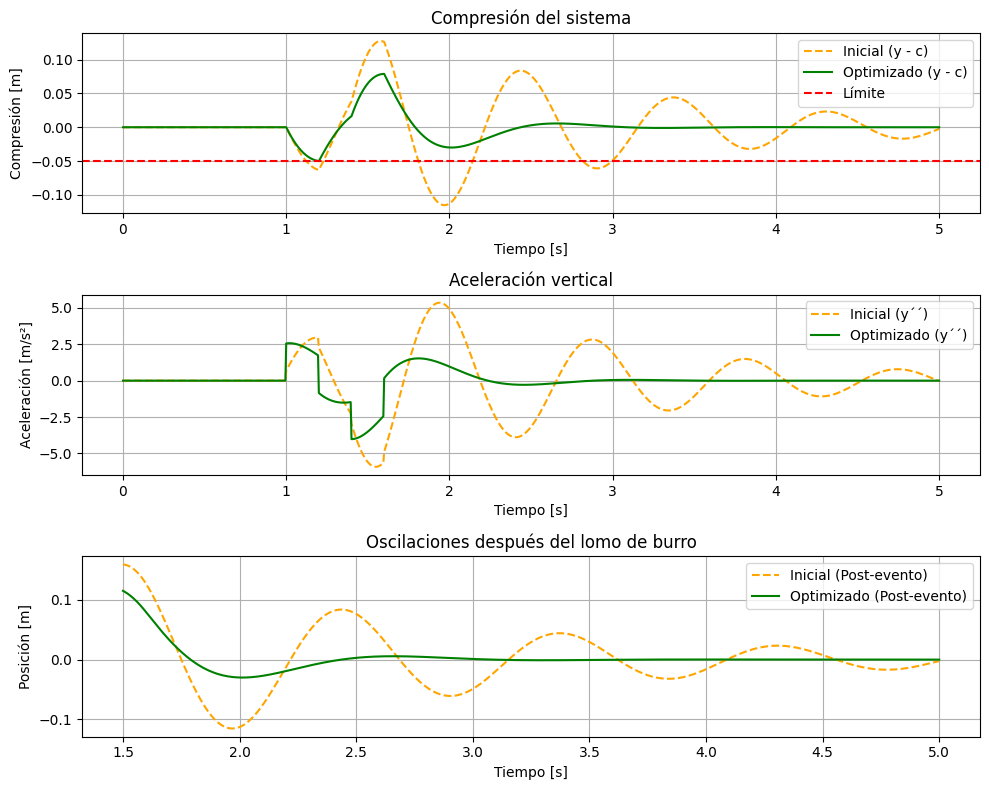

In [ ]:
# Simulación con valores iniciales
t_init, u_init, v_init, c_pos_init, c_vel_init = ponderado_implicito(
    0.5, dt, t_final, k, m, lmbda, c_func=obtener_c_segunda_parte
)

# Simulación con valores optimizados
t_opt, u_opt, v_opt, c_pos_opt, c_vel_opt = ponderado_implicito(
    0.5, dt, t_final, k_opt, m, lmbda_opt, c_func=obtener_c_segunda_parte
)

# Cálculo de aceleración para ambos casos
a_init = (k / m) * (c_pos_init - u_init) + (lmbda / m) * (c_vel_init - v_init)
a_opt = (k_opt / m) * (c_pos_opt - u_opt) + (lmbda_opt / m) * (c_vel_opt - v_opt)

# Índice donde inicia el análisis post-evento (ejemplo: t > 1.5 s)
post_event_index = int(1.5 / dt)

# Gráficas
plt.figure(figsize=(10, 8))

# Compresión
plt.subplot(3, 1, 1)
plt.plot(t_init, u_init - c_pos_init, label='Inicial (y - c)', linestyle='--', color='orange')
plt.plot(t_opt, u_opt - c_pos_opt, label='Optimizado (y - c)', linestyle='-', color='green')
plt.axhline(-0.05, color='red', linestyle='--', label='Límite')
plt.grid(True)
plt.legend()
plt.title('Compresión del sistema')
plt.xlabel('Tiempo [s]')
plt.ylabel('Compresión [m]')

# Aceleración
plt.subplot(3, 1, 2)
plt.plot(t_init, a_init, label='Inicial (y´´)', linestyle='--', color='orange')
plt.plot(t_opt, a_opt, label='Optimizado (y´´)', linestyle='-', color='green')
plt.grid(True)
plt.legend()
plt.title('Aceleración vertical')
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [m/s²]')

# Oscilaciones post-evento
plt.subplot(3, 1, 3)
plt.plot(
    t_init[post_event_index:], u_init[post_event_index:], label='Inicial (Post-evento)', linestyle='--', color='orange'
)
plt.plot(
    t_opt[post_event_index:], u_opt[post_event_index:], label='Optimizado (Post-evento)', linestyle='-', color='green'
)
plt.grid(True)
plt.legend()
plt.title('Oscilaciones después del lomo de burro')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')

plt.tight_layout()
plt.show()
